In [459]:
source('packages.r')
library('pROC')
load('/g/scb2/zeller/karcher/dysb_classif/data/siamcat/profiles_merged_with_metadata.rimage')

In [460]:
# REMEMBER to parse the results... with bash parse_results_wrapper.sh
# Also run this for now: for f in $(ls); do a=$(echo $f | sed "s/2022.*/\.tsv/"); mv ${f} ${a}; done
li <- list()
for (file in list.files("/g/scb2/zeller/karcher/dysb_classif/results_parsed/")) {
    #print(file)
    #read_tsv)str_c("/g/scb2/zeller/karcher/dysb_classifier/", file))
    #li[[length(li) + 1]] <- list(sc.obj.train.LOCO, sc.obj.test, sc.obj.train)
    #names(li)[length(li)] <- file
    li[[length(li) + 1]] <- suppressMessages(read_tsv(str_c("/g/scb2/zeller/karcher/dysb_classif/results_parsed/", file)) %>%
                                            mutate(featureEng = map_chr(featureEng, function(x) str_replace(x, "2022.*", ""))))
}

In [461]:
print(str_c("Total number of tests completed: ", length(li)))

[1] "Total number of tests completed: 902"


In [462]:
li <- do.call('rbind', li) %>% 
as_tibble() %>%
distinct(across(colnames(.)[!colnames(.) %in% c("auc")]), .keep_all = T)

In [463]:
li %>% dim()

[1] 891   8

In [464]:
# Complete dataframe for those AUCs whose computation isn't done yet
# CAREFUL: If you add new features you need to change this.
li <- li %>% 
complete(condition, 
         lowAbFiltering, 
         block, 
         MLalgorithm, 
         subsample, 
         genusLevel, 
         featureEng) %>%
mutate(auc = ifelse(is.na(auc), 0.5, auc))

In [475]:
li

condition,lowAbFiltering,block,MLalgorithm,subsample,genusLevel,featureEng,auc,withinConditionRank
<chr>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<dbl>,<dbl>
ACVD,FALSE,condition,lasso,FALSE,FALSE,FALSE,0.6998142,55.0
ACVD,FALSE,condition,lasso,FALSE,FALSE,TRUE,0.6826802,35.0
ACVD,FALSE,condition,lasso,FALSE,TRUE,FALSE,0.6594250,15.0
ACVD,FALSE,condition,lasso,FALSE,TRUE,TRUE,0.6543422,12.0
ACVD,FALSE,condition,lasso,TRUE,FALSE,FALSE,0.7612179,85.0
ACVD,FALSE,condition,lasso,TRUE,FALSE,TRUE,0.7628205,86.5
ACVD,FALSE,condition,lasso,TRUE,TRUE,FALSE,0.6714744,23.0
ACVD,FALSE,condition,lasso,TRUE,TRUE,TRUE,0.6506410,10.0
ACVD,FALSE,condition,lasso_ll,FALSE,FALSE,FALSE,0.6951413,50.0


### Maximum performance

For each condition, what is the highest attainable AUC. Note: Everything only with one resampling round, so there's some noise/'chance' reflected in these numbers, probably.

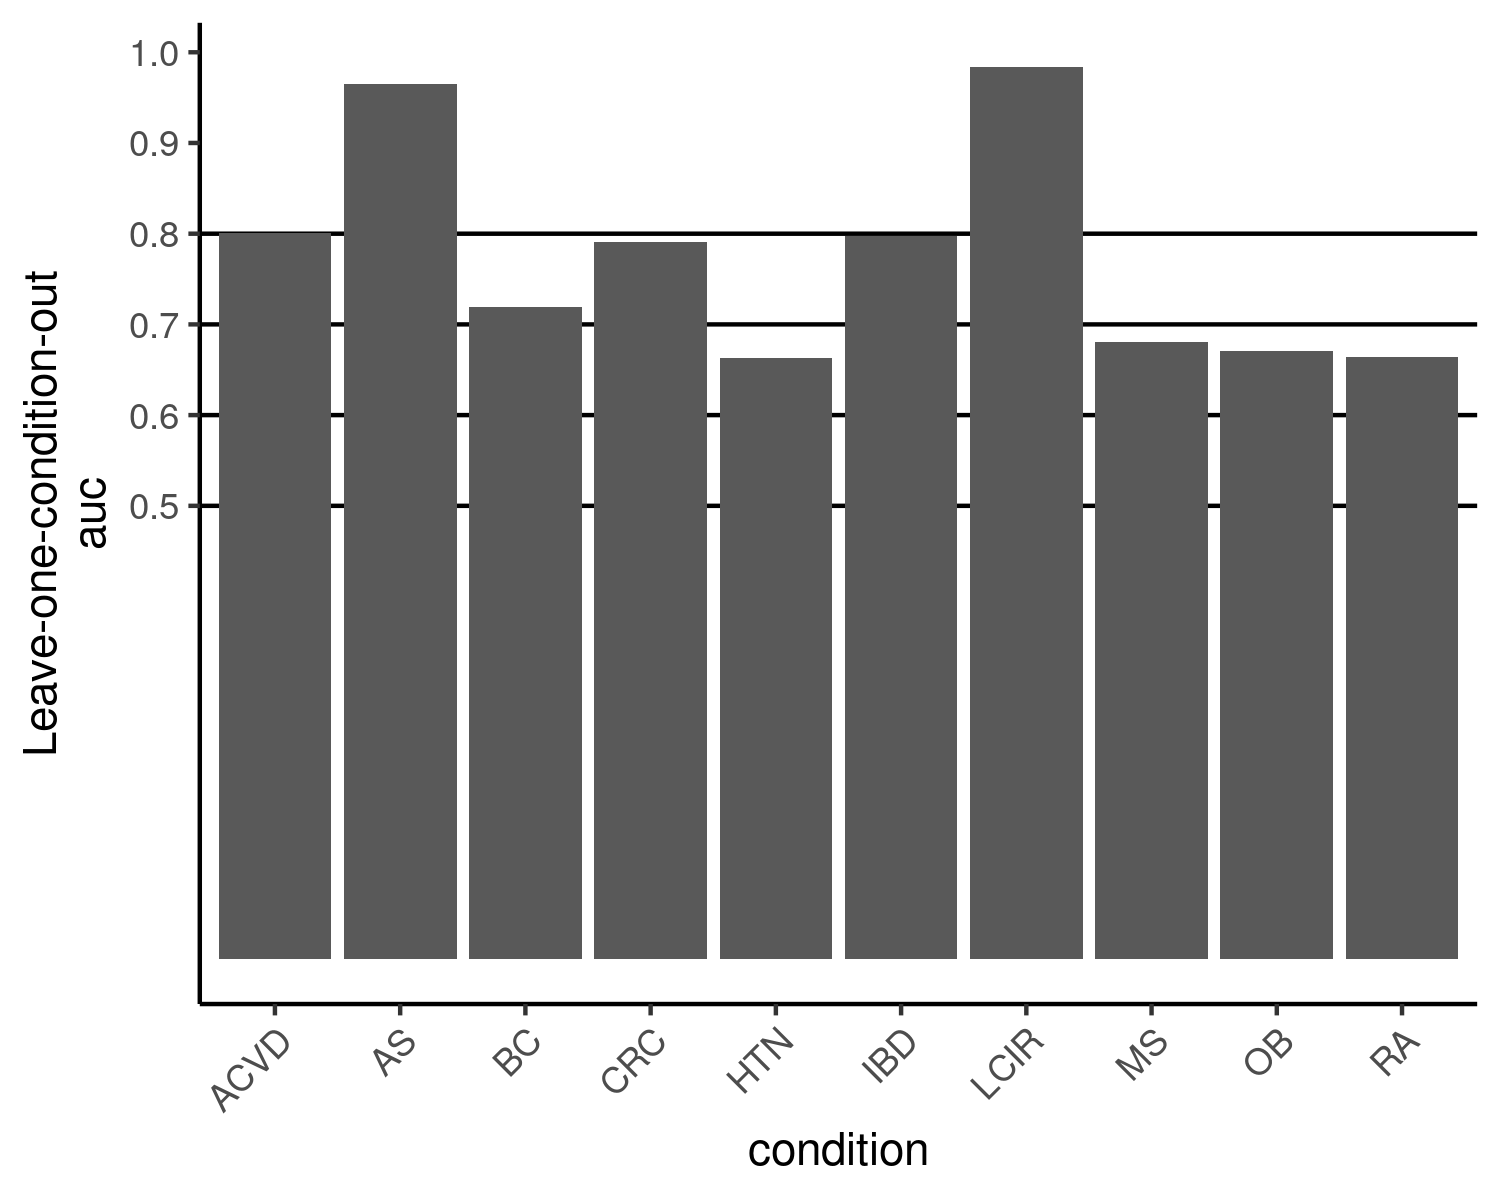

In [465]:
li %>% 
group_by(condition) %>% 
filter(auc == max(auc)) %>%
sample_n(1) %>%
ggplot(aes(x = condition, y = auc)) +
geom_hline(yintercept = 0.5) +
geom_hline(yintercept = 0.6) +
geom_hline(yintercept = 0.7) +
geom_hline(yintercept = 0.8) +
geom_bar(stat='identity') +
theme_classic() +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_y_continuous(breaks = seq(0.5, 1, 0.1)) +
ylab("Leave-one-condition-out\nauc")

### Most consistently well-performing combination

rank aucs within condition over parameter combs and then get parameter combination with highest mean rank 

In [471]:
li <- li %>% 
group_by(condition) %>% 
mutate(withinConditionRank = rank(auc)) %>%
ungroup()

In [473]:
best_performing <- li %>%
group_by(across(colnames(li)[!colnames(li) %in% c('condition', 'auc', 'withinConditionRank')])) %>%
nest() %>%
mutate(meanRank = map_dbl(data, function(x) mean(x$withinConditionRank))) %>%
mutate(medianRank = map_dbl(data, function(x) median(x$withinConditionRank))) %>%                          
mutate(meanAUC = map_dbl(data, function(x) mean(x$auc))) %>%                          
mutate(medianAUC = map_dbl(data, function(x) median(x$auc))) %>%                               
arrange(desc(medianRank)) %>%
head(1) %>%
tail(1) %>%
unnest()

best_performing                     

Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(data)`”


lowAbFiltering,block,MLalgorithm,subsample,genusLevel,featureEng,condition,auc,withinConditionRank,meanRank,medianRank,meanAUC,medianAUC
<lgl>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,ACVD,0.8012821,96.0,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,AS,0.5636071,26.0,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,BC,0.6727941,68.5,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,CRC,0.7359098,88.0,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,HTN,0.6210889,89.0,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,IBD,0.5892857,42.5,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,LCIR,0.7692308,41.0,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,MS,0.6075619,77.0,69.6,79,0.6618018,0.6303497
FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,OB,0.6396104,87.0,69.6,79,0.6618018,0.6303497


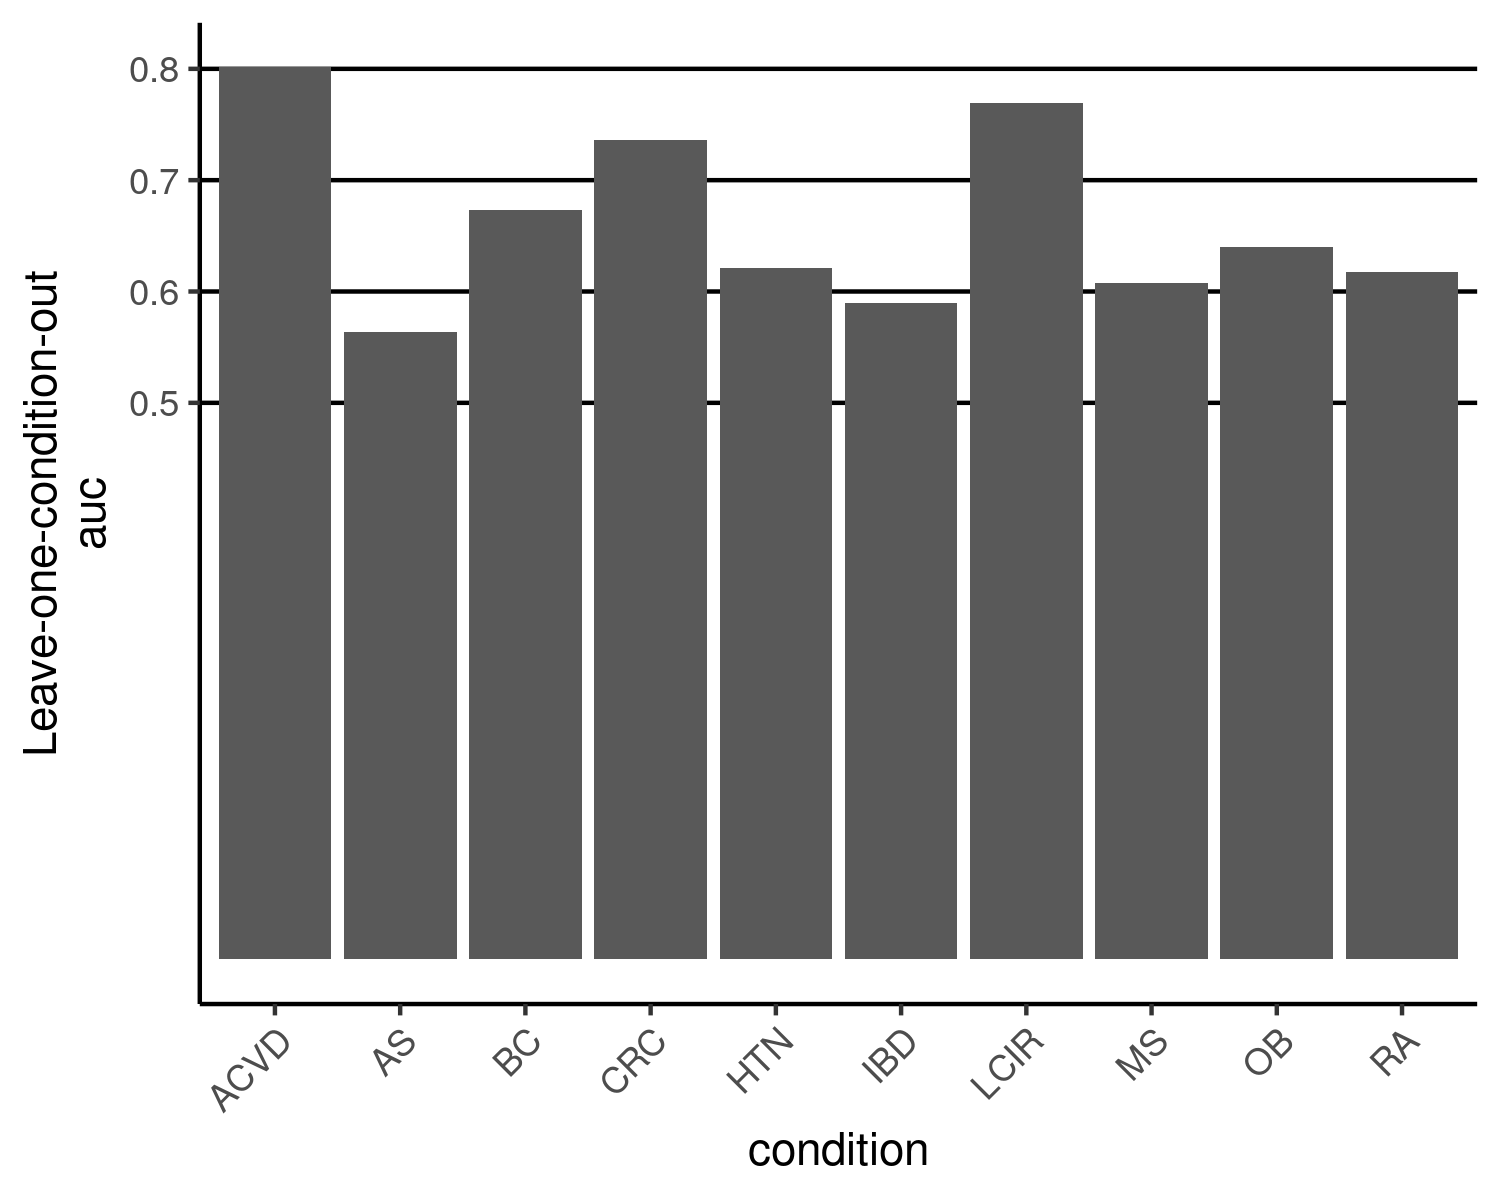

In [474]:
best_performing %>% 
ggplot(aes(x = condition, y = auc)) +
geom_hline(yintercept = 0.5) +
geom_hline(yintercept = 0.6) +
geom_hline(yintercept = 0.7) +
geom_hline(yintercept = 0.8) +
geom_bar(stat='identity') +
theme_classic() +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_y_continuous(breaks = seq(0.5, 1, 0.1)) +
ylab("Leave-one-condition-out\nauc")

## No low abundance filtering and subsampling of instances to equal-ish depths seems to be a good idea

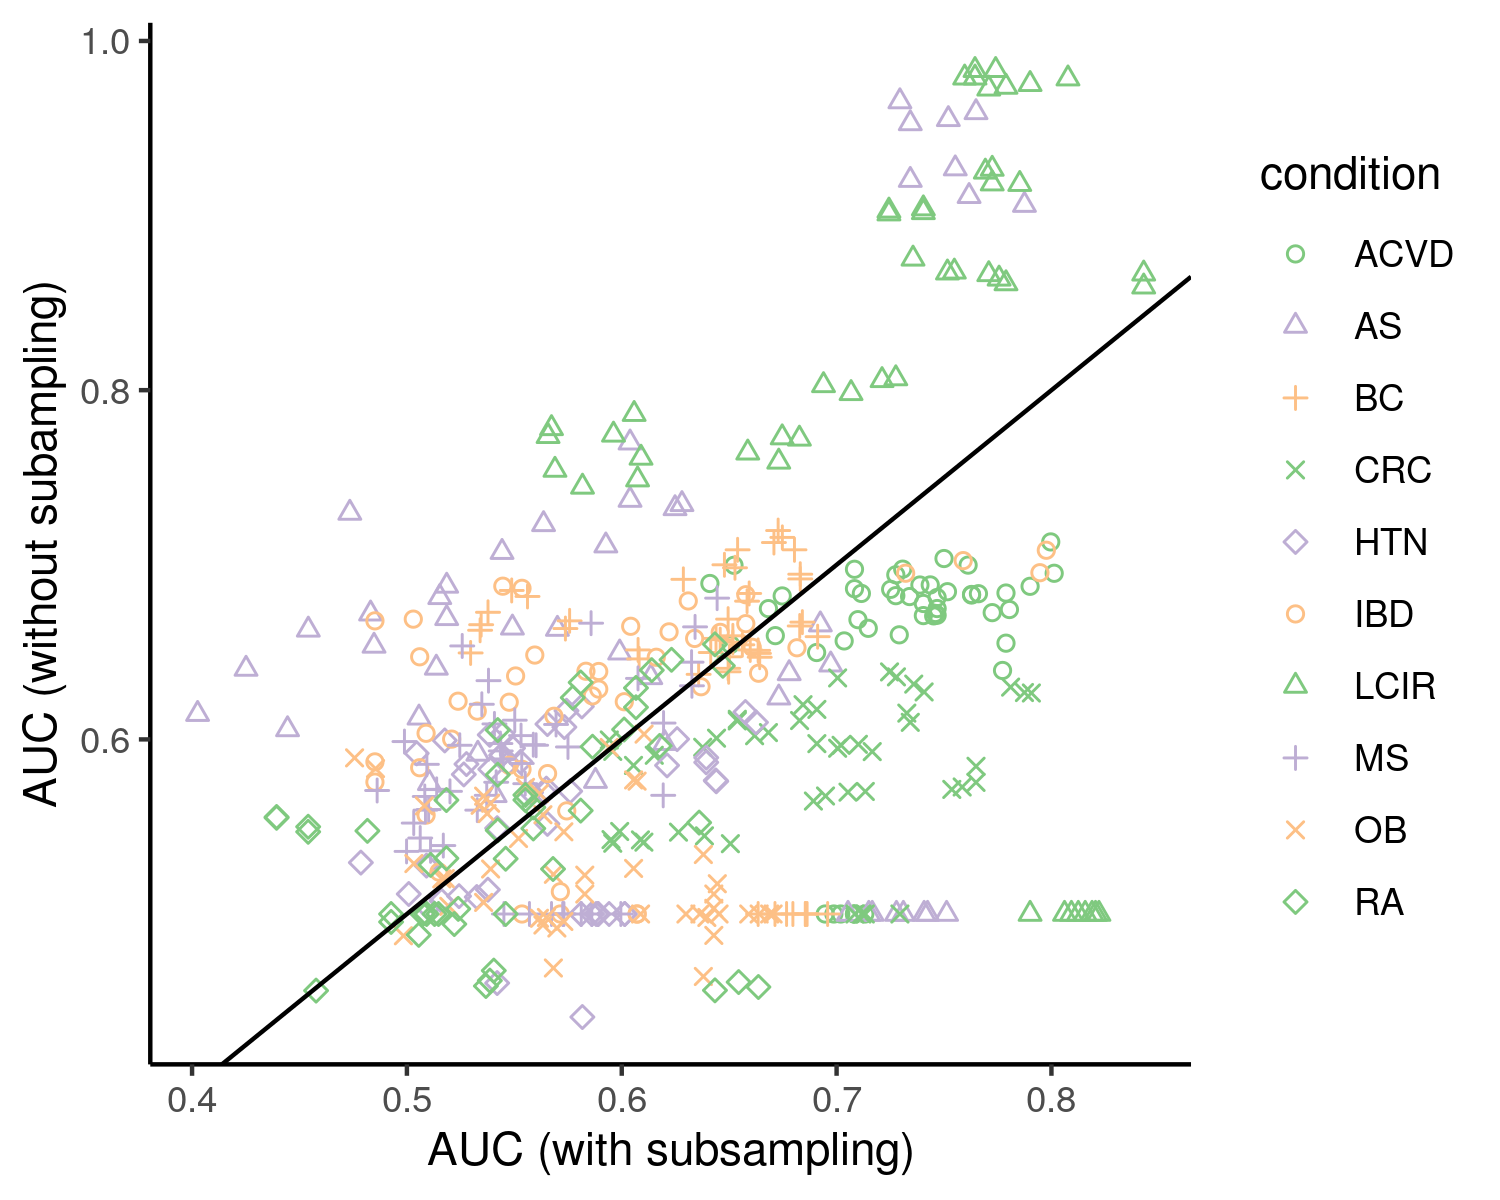

In [456]:
# Make sure that this is not flipped?!

options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
tmp <- li %>% 
select(-withinConditionRank) %>% 
pivot_wider(names_from = subsample, values_from = auc) %>%
mutate(condition = as.factor(condition))
p <-  tmp %>%
ggplot(aes(x=`TRUE`, y = `FALSE`)) +
geom_point(aes(color = condition, shape = condition)) +
theme_classic() +
xlab('AUC (with subsampling)') +
ylab('AUC (without subampling)') +
geom_abline(slope = 1, intercept = 0)
scale_color_shape_combined(p, var = tmp$condition, varName = 'condition', numShapes = 5)
#scale_shape_manual(name = 'condition', labels = levels(tmp$condition), values = c(1,2,3,1,2,3,1,2,3,1))


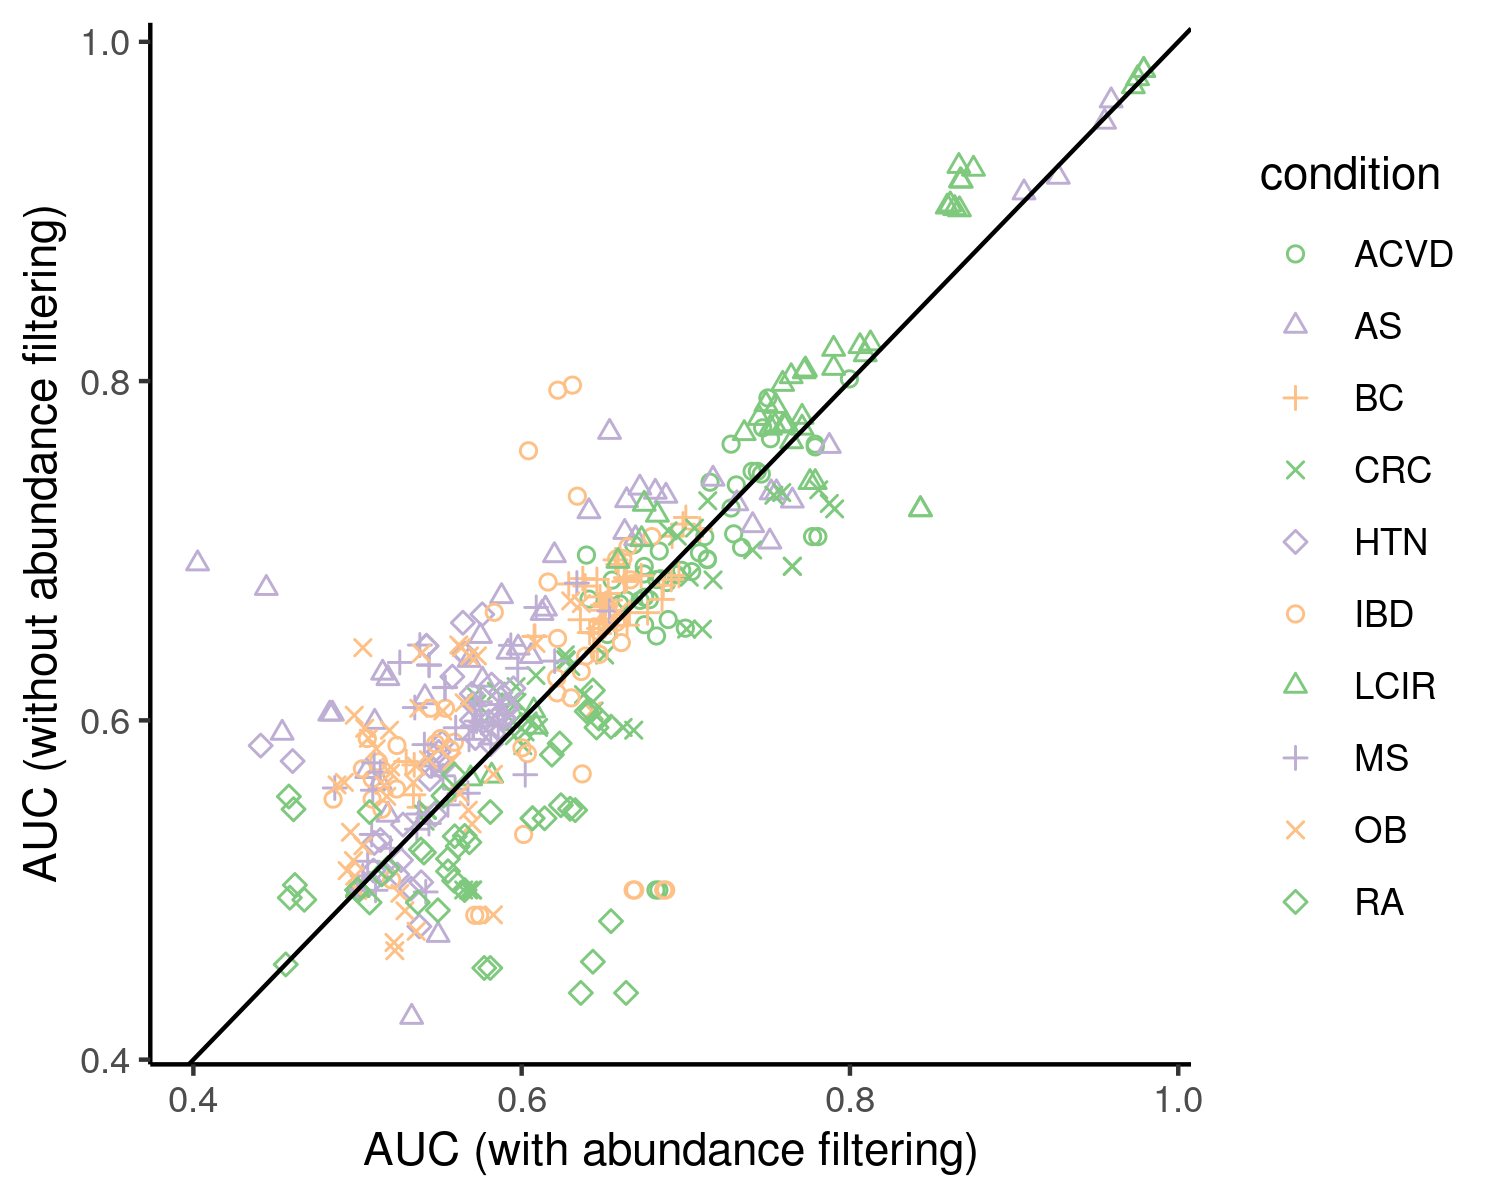

In [458]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 300)
tmp <- li %>% 
select(-withinConditionRank) %>% 
pivot_wider(names_from = lowAbFiltering, values_from = auc) %>%
mutate(condition = as.factor(condition))
p <-  tmp %>%
ggplot(aes(x=`TRUE`, y = `FALSE`)) +
geom_point(aes(color = condition, shape = condition)) +
theme_classic() +
xlab('AUC (with feature filtering)') +
ylab('AUC (without feature filtering)') +
geom_abline(slope = 1, intercept = 0)
scale_color_shape_combined(p, var = tmp$condition, varName = 'condition', numShapes = 5)
#scale_shape_manual(name = 'condition', labels = levels(tmp$condition), values = c(1,2,3,1,2,3,1,2,3,1))


## Feature Engineering

In [ ]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 300)
li %>% pivot_wider(names_from = featureEng, values_from = auc) %>%
rename(`Feature Engineering` = `TRUE`, `No Feature Engineering` = `FALSE`) %>%
ggplot(aes(x = `Feature Engineering`, y = `No Feature Engineering`)) +
geom_point(alpha = 0.2) +
geom_abline() +
theme_bw() 

In [160]:
# Are metadata-features even associated?
allDat <- getFeatures(dataMetaAdaptedTruncWideAll, metaDataWGS) 
morePredictorNames <- allDat[[2]]
allDat <- allDat[[1]] 
nn <- names(allDat)
stopifnot(all(map_dbl(allDat, length) == dim(dataMetaAdaptedTruncWideAll)[2]))                                 
tmpData <- matrix(unlist(allDat), byrow = T, nrow = length(allDat)) %>%
                                 as.data.frame()
colnames(tmpData) <- colnames(dataMetaAdaptedTruncWideAll)
rownames(tmpData) <- nn   
tmpData <- t(tmpData)
stopifnot(all(rownames(tmpData) == rownames(metaDataWGS)))
metaDataWGS <- metaDataWGS %>% 
                                 as.data.frame() %>% 
                                 mutate(sampleID = rownames(.)) %>% 
                                 left_join(tmpData %>% 
                                           as.data.frame() %>% 
                                           mutate(sampleID = rownames(.)), 
                                           by ='sampleID')                                
rownames(metaDataWGS) <- metaDataWGS$sampleID
metaDataWGS$sampleID <- NULL 

,caseControls,dataset,condition,richness,richnessAbsentInHC,cumAbundanceAbsentInHC,richnessPresentInHC,cumAbundancePresentInHC
,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
103_12M,control,Backhed_2015_CellHostMicrobe,No condition,128,30,0.0171125098,13,0.324744296
103_4M,control,Backhed_2015_CellHostMicrobe,No condition,40,7,0.0405916753,3,0.001031992
103_B,control,Backhed_2015_CellHostMicrobe,No condition,42,12,0.2140650287,1,0.020597322
103_M,control,Backhed_2015_CellHostMicrobe,No condition,274,19,0.0136012992,21,0.156110434
105_12M,control,Backhed_2015_CellHostMicrobe,No condition,84,12,0.0144482572,12,0.597074228
105_4M,control,Backhed_2015_CellHostMicrobe,No condition,77,27,0.0250077664,6,0.008232370
105_B,control,Backhed_2015_CellHostMicrobe,No condition,20,3,0.0156402737,2,0.056500489
105_M,control,Backhed_2015_CellHostMicrobe,No condition,287,19,0.0107858243,21,0.177195686
10_12M,control,Backhed_2015_CellHostMicrobe,No condition,146,5,0.0007793017,20,0.428771820


In [231]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
library(patchwork)
getPlots <- function(var) {
    aucs1 <-  suppressMessages(metaDataWGS %>% 
    filter(condition != 'No condition') %>%
    filter(condition != 'CDI') %>%
    group_by(condition) %>% 
    nest() %>%
    mutate(auc = map_dbl(data, function(x) {
        return(roc(x$caseControls, x[[var]])$auc)
    })) %>%
    select(condition, auc) %>%
    mutate(auc = map_dbl(auc, function(x) round(x, 2))))
                         
    aucs2 <-  suppressMessages(metaDataWGS %>% 
    filter(condition != 'No condition') %>%
    filter(condition != 'CDI') %>%
    mutate(condition = "a") %>%                               
    group_by(condition) %>% 
    nest() %>%                               
    mutate(auc = map_dbl(data, function(x) {
        return(roc(x$caseControls, x[[var]])$auc)
    })) %>%
    select(condition, auc) %>%
    mutate(auc = map_dbl(auc, function(x) round(x, 2))))
                         
    
    (ggplot() +
    geom_boxplot(data = metaDataWGS %>% 
    filter(condition != 'No condition'), aes(x = condition, y = .data[[var]], fill = caseControls)) + 
    geom_text(data = aucs1, aes(x = condition, y = max(metaDataWGS[[var]])*1.05, label = auc), size = 4, angle = 45) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 45, hjust  = 1))) +
    (ggplot() +
    #annotate(geom = "text", x = 1.5, y = max(metaDataWGS[[var]])*1.05, label = round(aucs2, 2))    +                                                               
    geom_text(data = aucs2, aes(x = "case", y = max(metaDataWGS[[var]])*1.05, label = auc)) + 
    geom_boxplot(data = metaDataWGS %>% 
    filter(condition != 'No condition'), aes(x = caseControls, y = .data[[var]])) + 
    ylab(var) + 
    theme_bw())
}

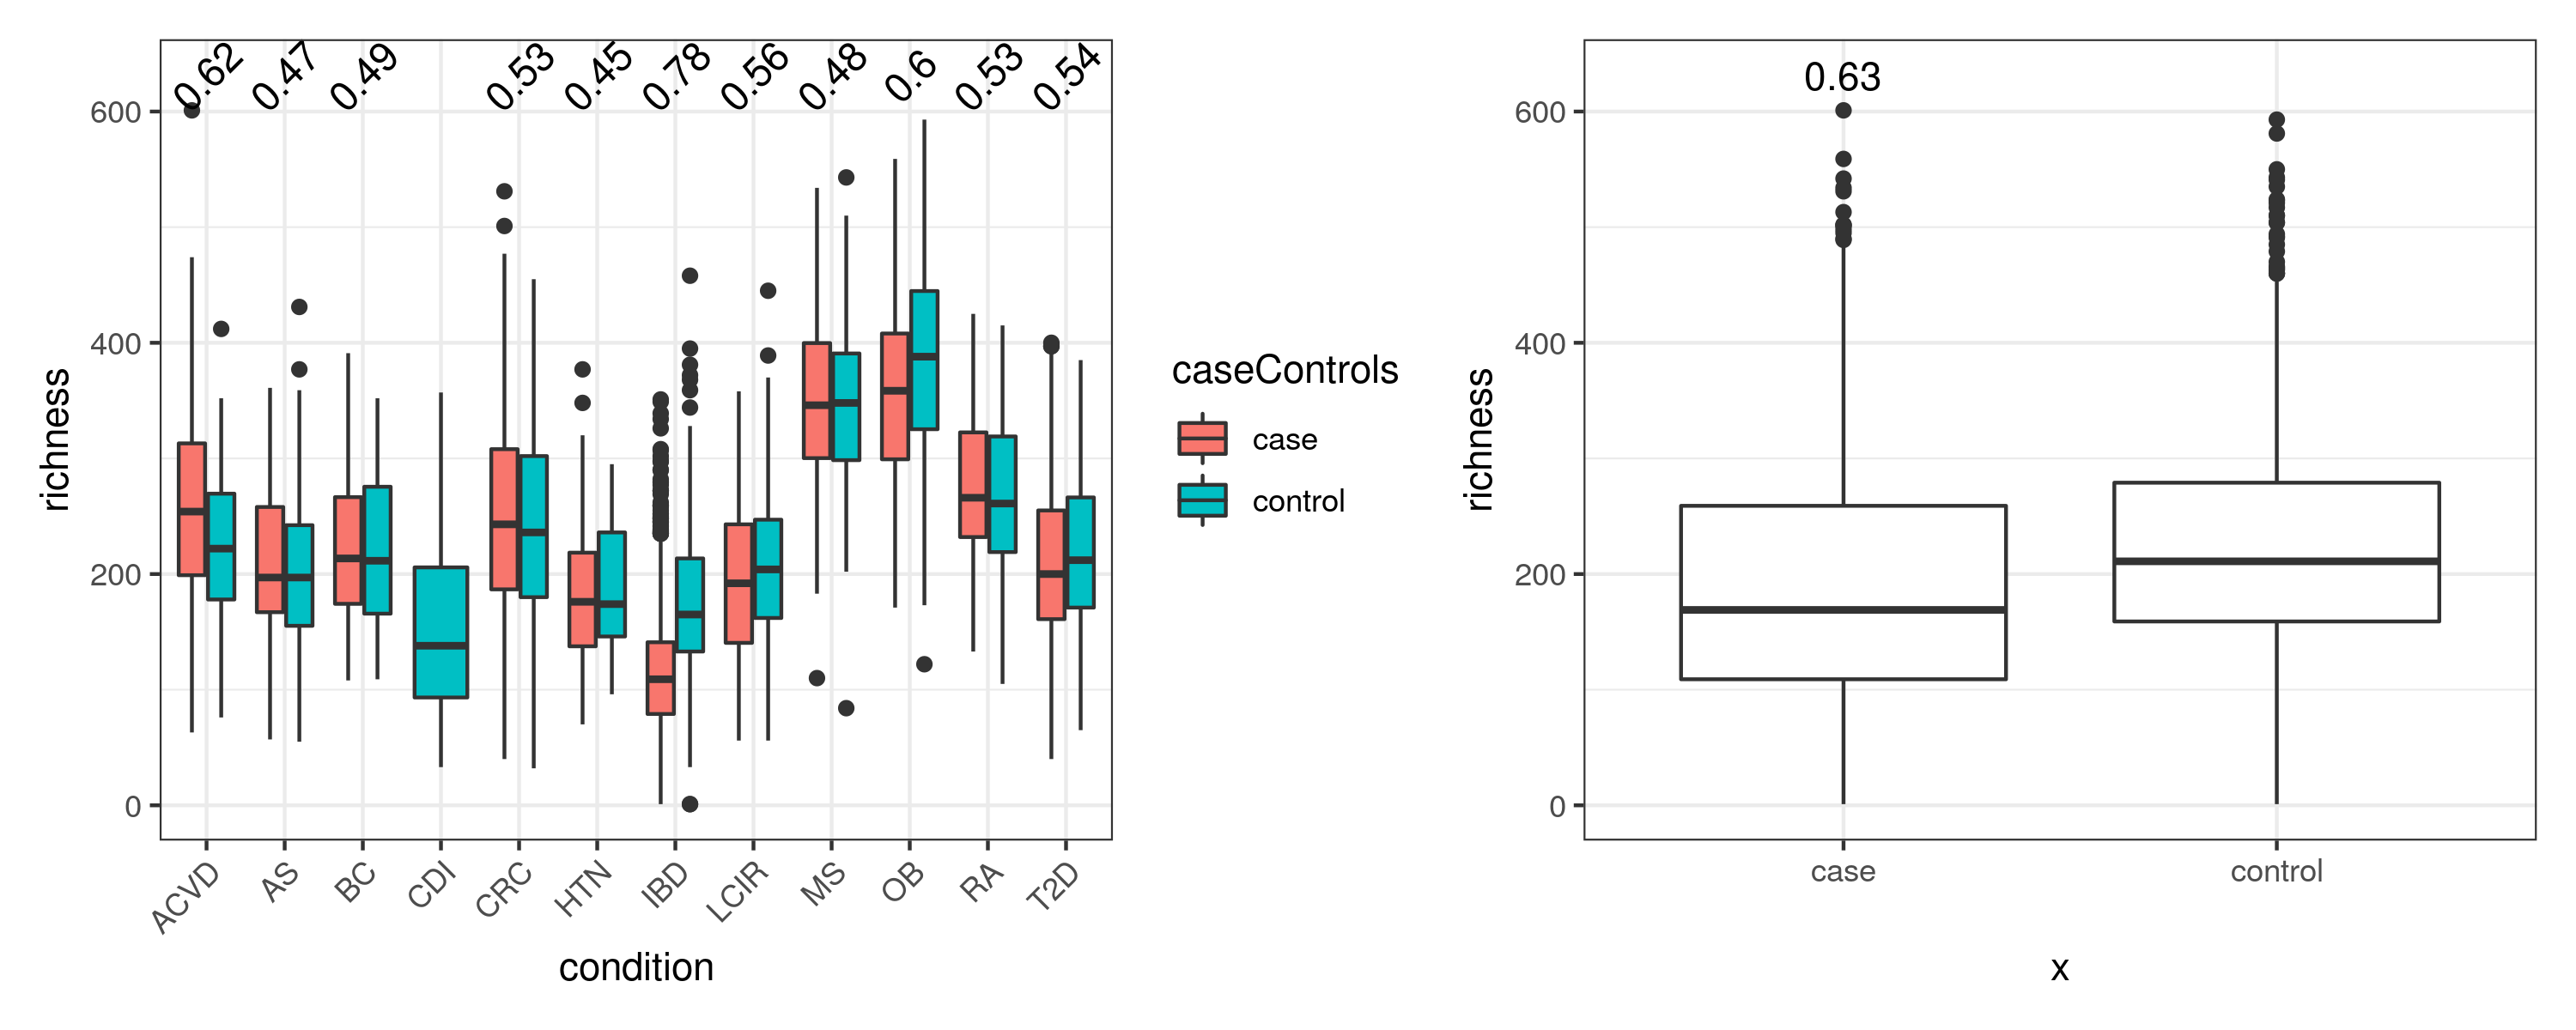

In [232]:
getPlots("richness")

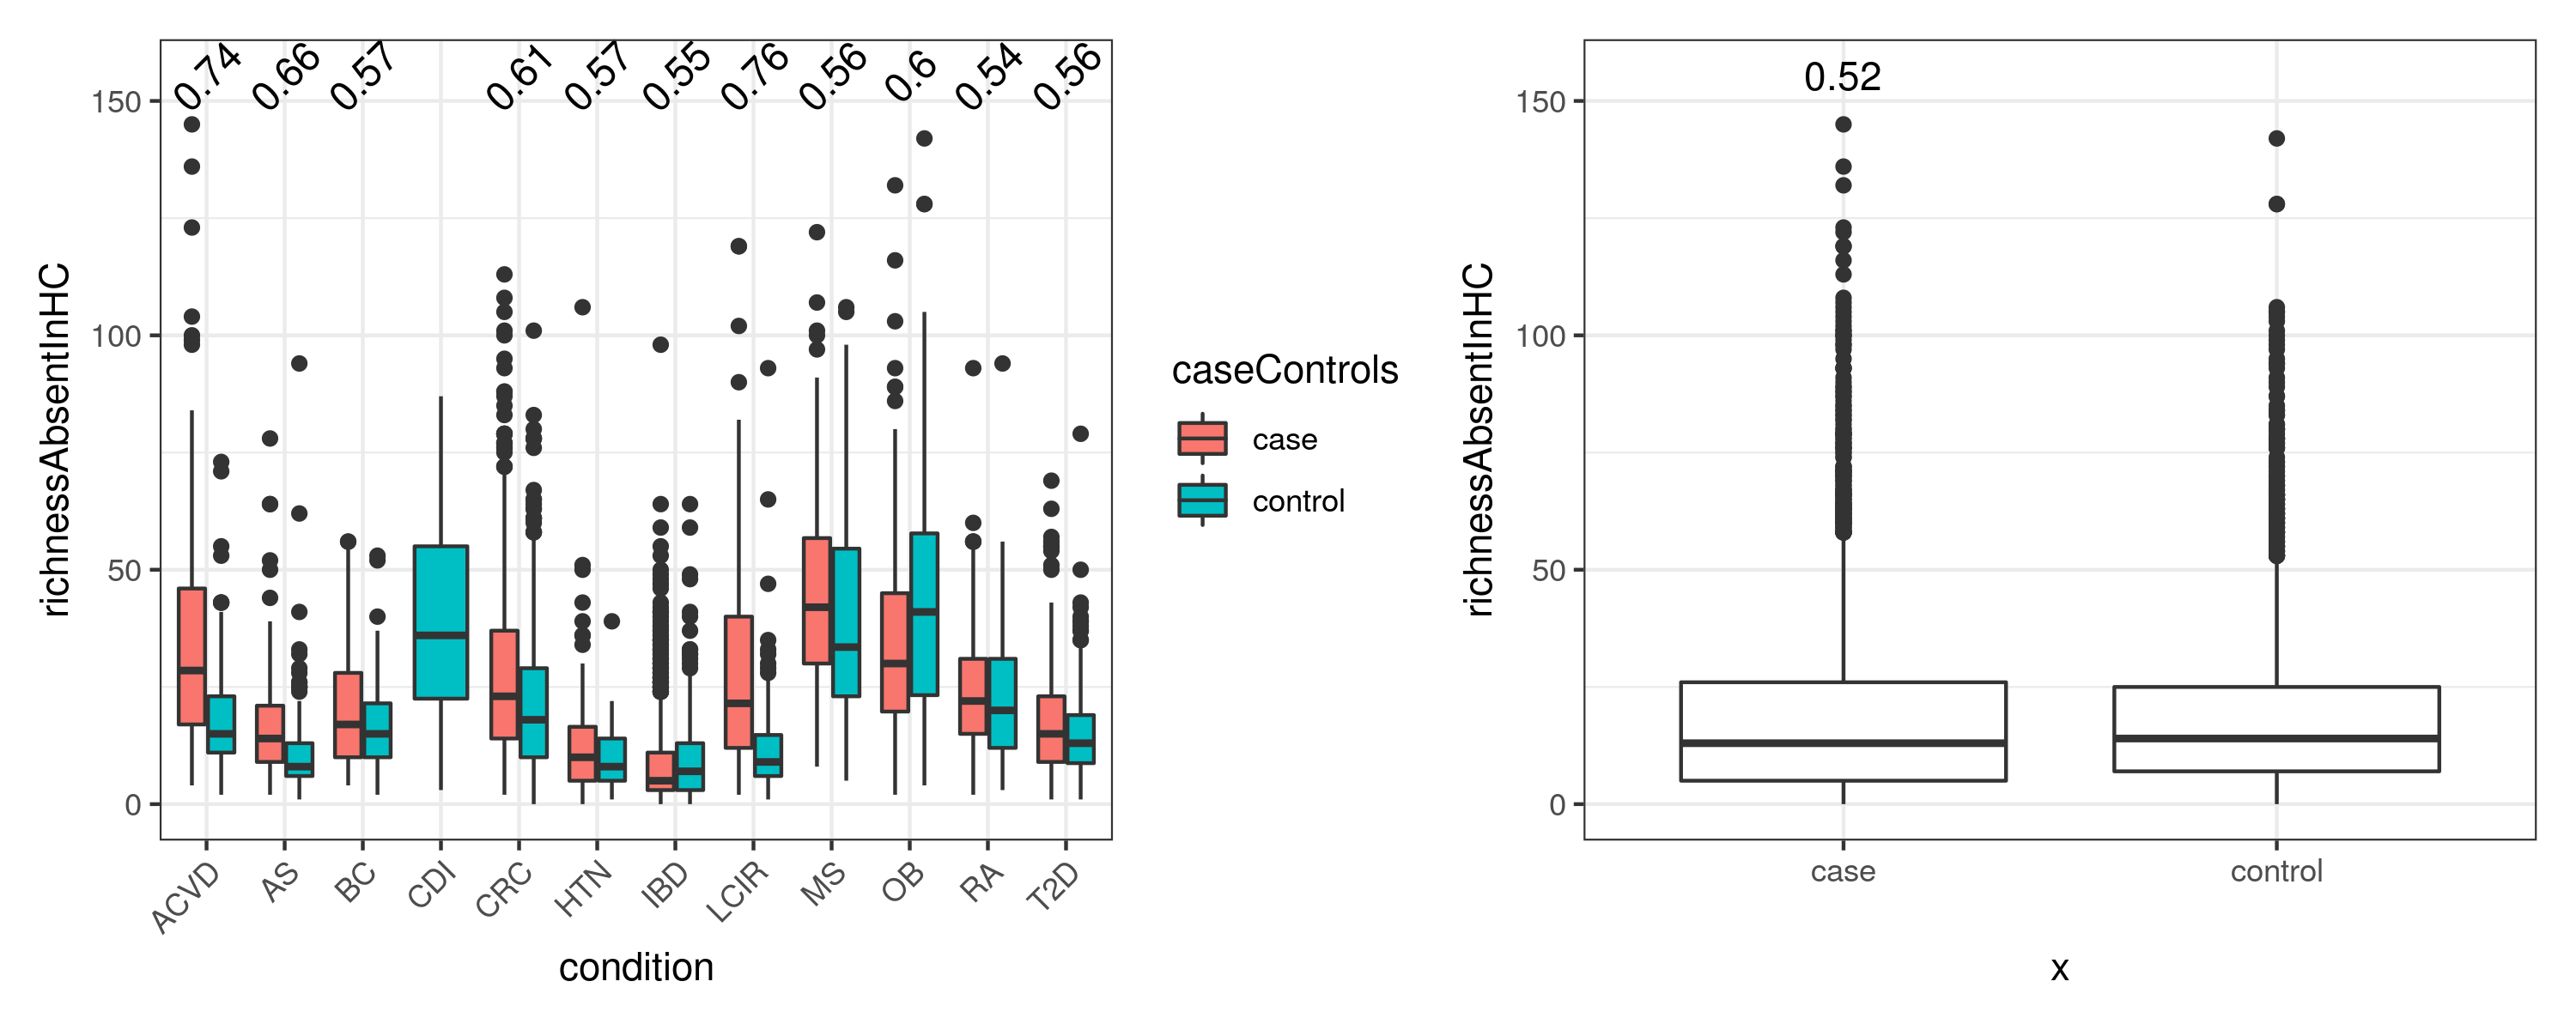

In [234]:
getPlots('richnessAbsentInHC')

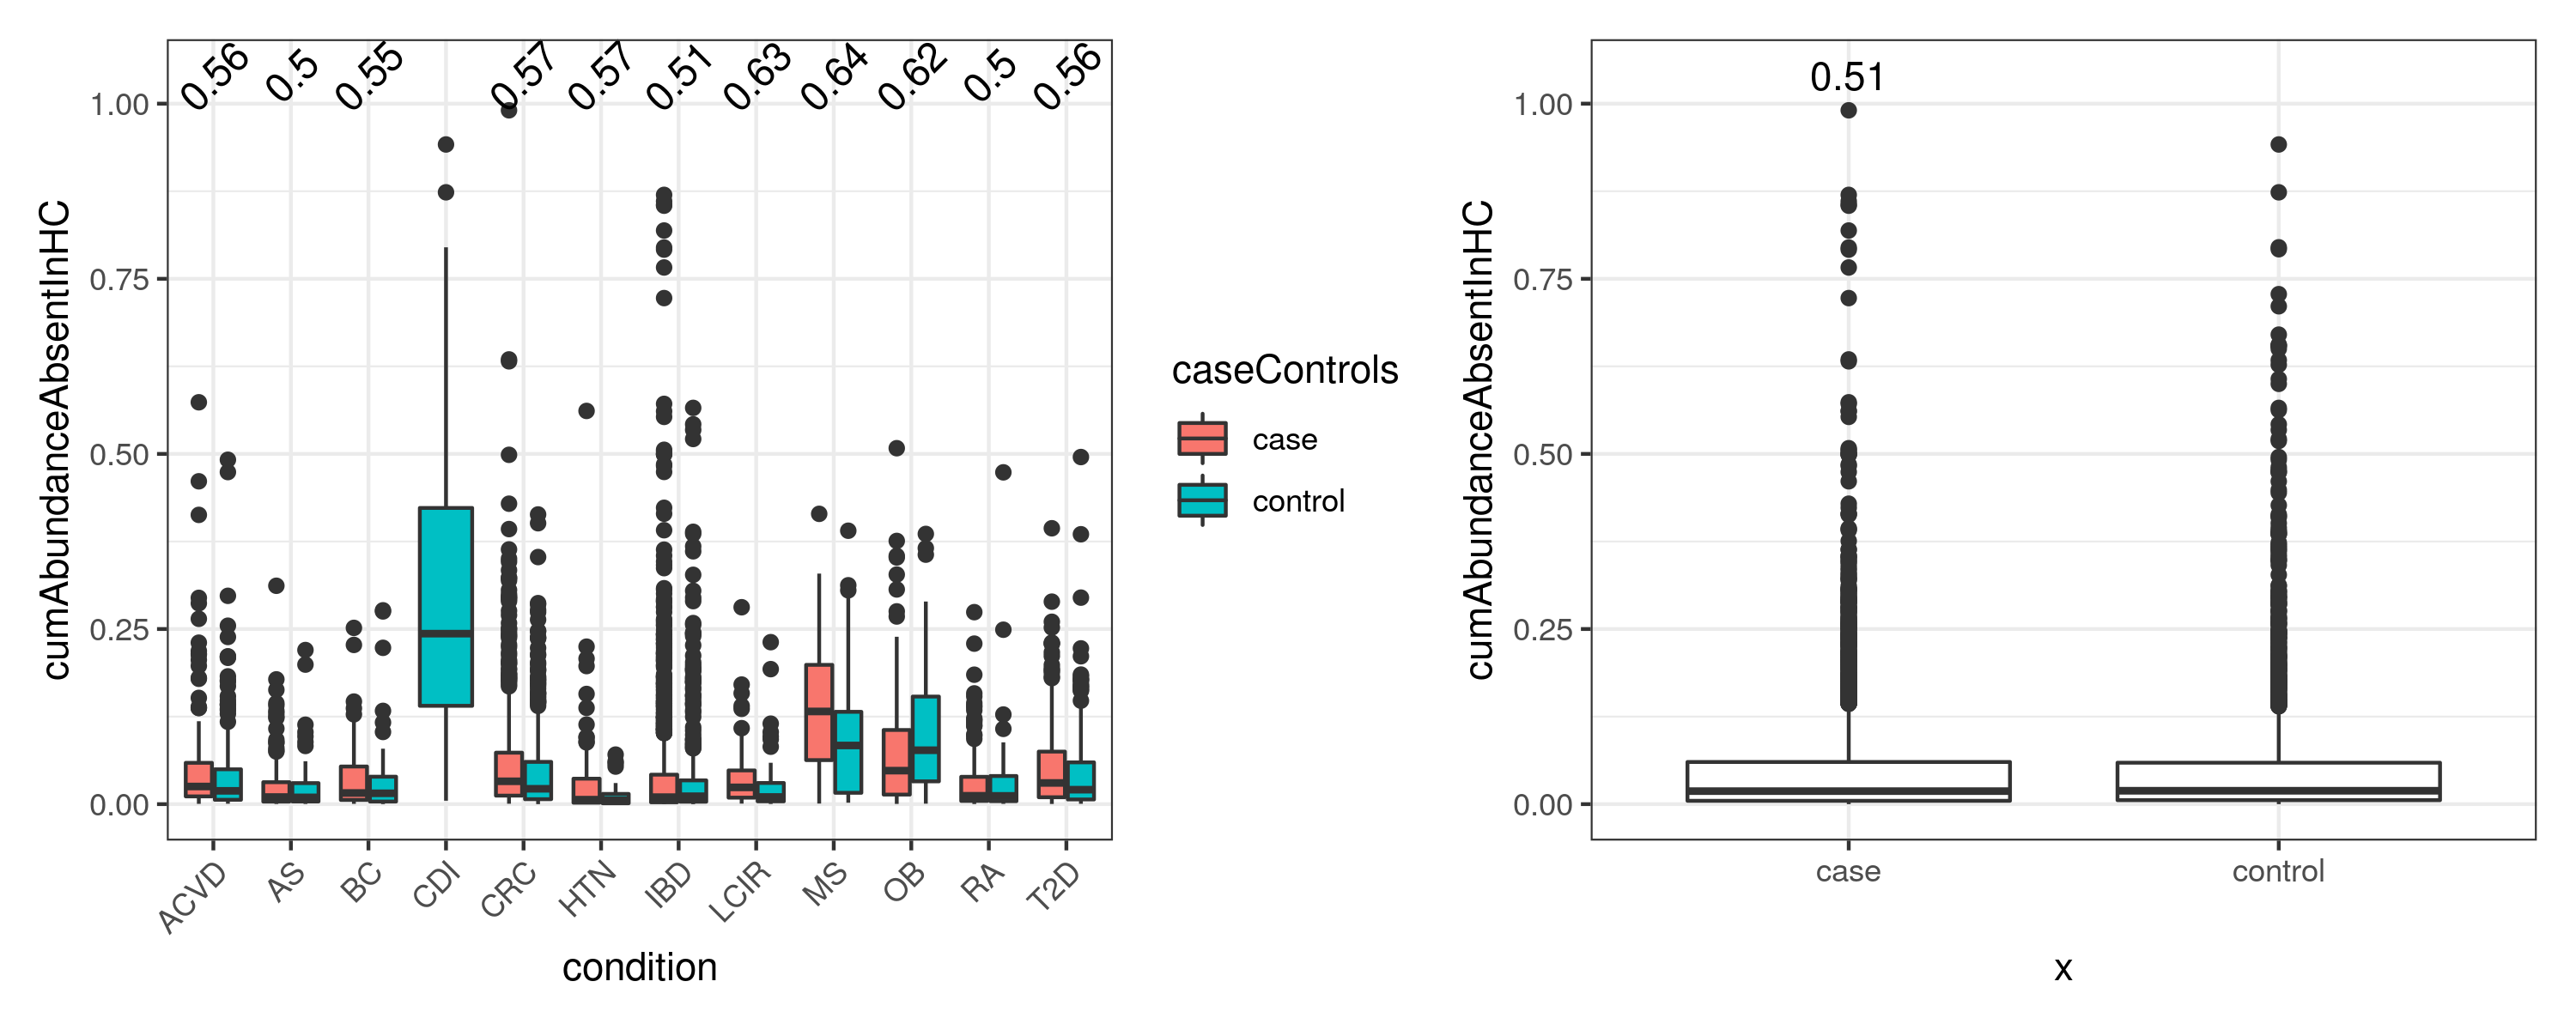

In [236]:
getPlots('cumAbundanceAbsentInHC')

condition,lowAbFiltering,block,MLalgorithm,subsample,genusLevel,featureEng,auc
<chr>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<dbl>
ACVD,FALSE,condition,lasso,FALSE,FALSE,FALSE,0.6998142
ACVD,FALSE,condition,lasso,FALSE,FALSE,TRUE,0.6826802
ACVD,FALSE,condition,lasso,FALSE,TRUE,FALSE,0.6594250
ACVD,FALSE,condition,lasso,FALSE,TRUE,TRUE,0.6543422
ACVD,FALSE,condition,lasso,TRUE,FALSE,FALSE,0.7612179
ACVD,FALSE,condition,lasso,TRUE,FALSE,TRUE,0.7628205
ACVD,FALSE,condition,lasso,TRUE,TRUE,FALSE,0.6714744
ACVD,FALSE,condition,lasso,TRUE,TRUE,TRUE,0.6506410
ACVD,FALSE,condition,lasso_ll,FALSE,FALSE,FALSE,0.6951413


condition,lowAbFiltering,block,MLalgorithm,subsample,genusLevel,featureEng,auc
<chr>,<lgl>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<dbl>
ACVD,FALSE,condition,lasso_ll,TRUE,FALSE,FALSE,0.8012821
AS,TRUE,condition,RF,FALSE,TRUE,TRUE,0.9269307
BC,FALSE,condition,lasso_ll,FALSE,FALSE,FALSE,0.7196078
CRC,TRUE,no_blocking,lasso_ll,TRUE,FALSE,FALSE,0.7906602
HTN,FALSE,no_blocking,lasso_ll,TRUE,FALSE,TRUE,0.6624784
IBD,FALSE,condition,RF,TRUE,TRUE,FALSE,0.7976190
LCIR,TRUE,condition,RF,FALSE,TRUE,TRUE,0.9752453
MS,FALSE,no_blocking,lasso_ll,FALSE,FALSE,TRUE,0.6808996
OB,FALSE,condition,RF,TRUE,FALSE,TRUE,0.6704545


In [ ]:
metaDataWGS

## TODO

- Incoorporate the 16S profiles...

In [ ]:
# Duvallet...
system("ls  /g/zeller/jawirbel/siamcat_paper/duvallet_reproduction/microbiomeHD/data/clean_tables", intern=TRUE)